<a href="https://colab.research.google.com/github/knattarina/wildfire_challenge/blob/main/SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

In [1]:
!pip install pmdarima 

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import os
import warnings 
import pmdarima

from pmdarima import auto_arima 
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Wildfire_Challenge/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing Data and select Training Region

In [2]:
forecasts_df = pd.read_csv('Cleansed_Forecasts.csv')
df = pd.read_csv('Cleansed_Data.csv')

forecasts_df['Date'] = pd.to_datetime(forecasts_df['Date'])
df['Date'] = pd.to_datetime(df['Date'])

columns = ['Region', 'Mean_estimated_fire_brightness', 'Mean_estimated_fire_radiative_power',	'Mean_confidence']

df_region = df[df['Region'] == 'QL'].copy()
df_region.drop(columns = columns, inplace = True)

QL_fires = df_region[['Date', 'Estimated_fire_area']]
QL_fires.set_index('Date', inplace=True)
QL_fires.head()

,Estimated_fire_area
Date,
2005-01-01,38.831579
2005-01-02,64.464286
2005-01-03,47.386585
2005-01-04,30.100000
2005-01-05,4.000000


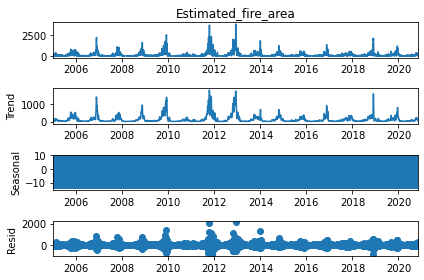

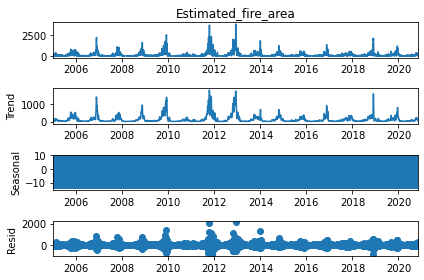

In [3]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(QL_fires['Estimated_fire_area'], model ='additive', extrapolate_trend='freq') 
result.plot() 

Testing if data is stationary or not

 > Is the raw data stationary ?
Test statistic = -6.223
P-value = 0.000
Critical values :
	1%: -3.4314875797597644 - The data is  stationary with 99% confidence
	5%: -2.8620427016919505 - The data is  stationary with 95% confidence
	10%: -2.5670375862348798 - The data is  stationary with 90% confidence


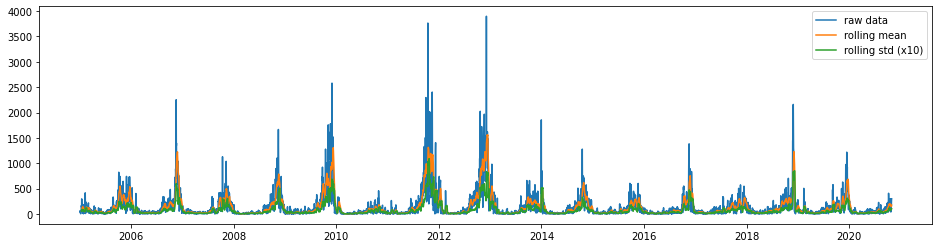

In [4]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title):
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))


pd.options.display.float_format = '{:.8f}'.format
test_stationarity(QL_fires['Estimated_fire_area'],'raw data')

ADF_test(QL_fires['Estimated_fire_area'],'raw data')

Split Data to Training and Dataset

In [5]:
y_to_train = QL_fires[:'2019-11-30']['Estimated_fire_area'] # dataset to train
y_to_val = QL_fires['2019-11-30':]['Estimated_fire_area'] # last X months for test  
predict_date = 28 # len(QL_fires) - len(QL_fires[:'2019-01-31']) # the number of data points for the test set
y = QL_fires[:'2019-12-01']['Estimated_fire_area']

##**Simple Exponential Smoothing**

The visualization of the results for the simple exponential smoothing (SES) forecast model shows the difference between the specified α (blue line) and the auto-optimized α (green line). As you can see from the graph, SES will predict a flat, forecasted line since the logic behind it uses weighted averages. Even though the RMSE is low, it does not predict any fluctuation. Since most time series data has some kind of trend or seasonality, this model can be used to get a sense of a baseline for comparison.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,


The Root Mean Squared Error of our forecasts with smoothing level of 0.8 is 440.36
The Root Mean Squared Error of our forecasts with auto optimization is 450.58


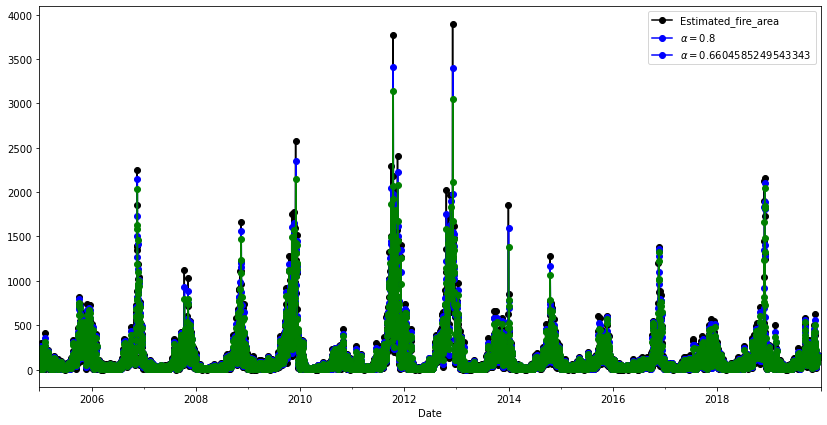

In [6]:
from statsmodels.tsa.api import SimpleExpSmoothing 

def ses(y, y_to_train,y_to_test,smoothing_level,predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = SimpleExpSmoothing(y_to_train).fit(smoothing_level=smoothing_level,optimized=False)
    fcast1 = fit1.forecast(predict_date).rename(r'$\alpha={}$'.format(smoothing_level))
    # specific smoothing level
    fcast1.plot(marker='o', color='blue', legend=True)
    fit1.fittedvalues.plot(marker='o',  color='blue')
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with smoothing level of {} is {}'.format(smoothing_level,round(np.sqrt(mse1), 2)))
    
    ## auto optimization
    fit2 = SimpleExpSmoothing(y_to_train).fit()
    fcast2 = fit2.forecast(predict_date).rename(r'$\alpha=%s$'%fit2.model.params['smoothing_level'])
    # plot
    fcast2.plot(marker='o', color='green', legend=True)
    fit2.fittedvalues.plot(marker='o', color='green')
    
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of our forecasts with auto optimization is {}'.format(round(np.sqrt(mse2), 2)))
    
    plt.show()

ses(y, y_to_train,y_to_val,0.8,predict_date)

## **Holt’s Linear Trend Method**

Looking at the visualization for the Holt method, we see how the linear trend (blue line) and exponential trend (red line) compare to each other and to the order volumes. Compared with SES, Holt captures more of the trend of the data. However, as you can see from the visual, the trend it discovered is too dramatic and would be very unlikely to take place in real life.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


The Root Mean Squared Error of Holts Linear trend 437.15
The Root Mean Squared Error of Holts Exponential trend 1644.84


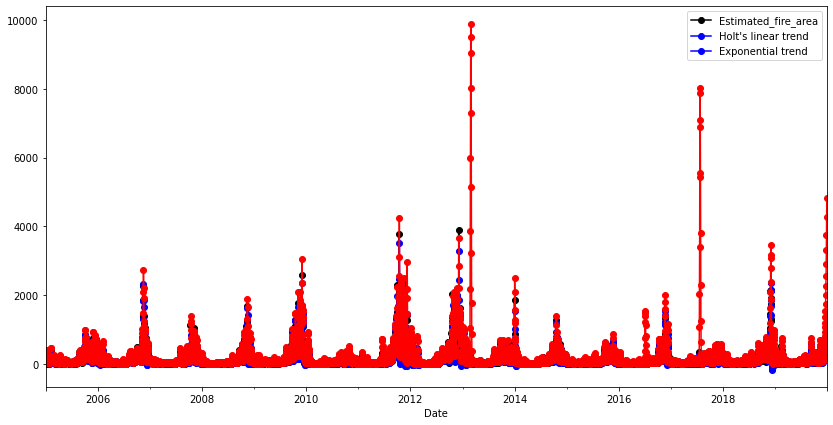

In [7]:
from statsmodels.tsa.api import Holt

def holt(y,y_to_train,y_to_test,smoothing_level,smoothing_slope, predict_date):
    y.plot(marker='o', color='black', legend=True, figsize=(14, 7))
    
    fit1 = Holt(y_to_train).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast1 = fit1.forecast(predict_date).rename("Holt's linear trend")
    mse1 = ((fcast1 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Linear trend {}'.format(round(np.sqrt(mse1), 2)))

    fit2 = Holt(y_to_train, exponential=True).fit(smoothing_level, smoothing_slope, optimized=False)
    fcast2 = fit2.forecast(predict_date).rename("Exponential trend")
    mse2 = ((fcast2 - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of Holt''s Exponential trend {}'.format(round(np.sqrt(mse2), 2)))
    
    fit1.fittedvalues.plot(marker="o", color='blue')
    fcast1.plot(color='blue', marker="o", legend=True)
    fit2.fittedvalues.plot(marker="o", color='red')
    fcast2.plot(color='red', marker="o", legend=True)

    plt.show()

holt(y, y_to_train,y_to_val,0.6,0.2,predict_date)

## **Holt-Winters’ Seasonal Method**
The visualization of the results for the Holt-Winters method shows the additive (red line) compared to the additive + damped (green line) trends. Based on the visualization, we see that the Holt-Winters model fits the actual data best, so far. However, the RMSE is not better than the results from the simple SES model. And we can also tell that the forecast starts to drop off towards the end.



/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


The Root Mean Squared Error of additive trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 481.66


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


The Root Mean Squared Error of additive damped trend, multiplicative seasonal of period season_length=52 and a Box-Cox transformation 481.66


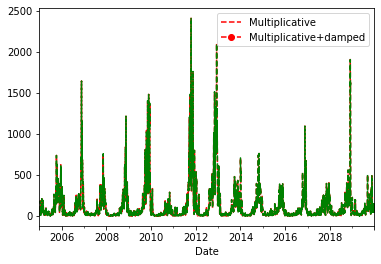

In [8]:
from statsmodels.tsa.api import ExponentialSmoothing

def holt_win_sea(y,y_to_train,y_to_test,seasonal_type,seasonal_period,predict_date):
    
    #y.plot(marker='o', color='lightgrey', legend=True, figsize=(14, 7))
    
    if seasonal_type == 'additive':
        fit1 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add').fit(use_boxcox=True)
        fcast1 = fit1.forecast(predict_date).rename('Additive')
        mse1 = ((fcast1 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse1), 2)))
        
        fit2 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='add', damped=True).fit(use_boxcox=True)
        fcast2 = fit2.forecast(predict_date).rename('Additive+damped')
        mse2 = ((fcast2 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, additive seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse2), 2)))
        
        fit1.fittedvalues.plot(style='--', color='red')
        fcast1.plot(style='--', marker='o', color='red', legend=True)
        fit2.fittedvalues.plot(style='--', color='green')
        fcast2.plot(style='--', marker='o', color='green', legend=True)
    
    elif seasonal_type == 'multiplicative':  
        fit3 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul').fit(use_boxcox=True)
        fcast3 = fit3.forecast(predict_date).rename('Multiplicative')
        mse3 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse3), 2)))
        
        fit4 = ExponentialSmoothing(y_to_train, seasonal_periods = seasonal_period, trend='add', seasonal='mul', damped=True).fit(use_boxcox=True)
        fcast4 = fit4.forecast(predict_date).rename('Multiplicative+damped')
        mse4 = ((fcast3 - y_to_test) ** 2).mean()
        print('The Root Mean Squared Error of additive damped trend, multiplicative seasonal of '+ 
              'period season_length={} and a Box-Cox transformation {}'.format(seasonal_period,round(np.sqrt(mse4), 2)))
        
        fit3.fittedvalues.plot(style='--', color='red')
        fcast3.plot(style='--', marker='o', color='red', legend=True)
        fit4.fittedvalues.plot(style='--', color='green')
        fcast4.plot(style='--', marker='o', color='green', legend=True)
        
    else:
        print('Wrong Seasonal Type. Please choose between additive and multiplicative')

    plt.show()
holt_win_sea(y, y_to_train,y_to_val,'multiplicative',52, predict_date)

## **SARIMA**



Trend Elements:

*   p: Trend autoregression order.
*   d: Trend difference order.
*   q: Trend moving average order.

Seasonal Elements:
*   P: Seasonal autoregressive order.
*   D: Seasonal difference order.
*   Q: Seasonal moving average order.
*   m: The number of time steps for a single seasonal period.




In [37]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
            
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    mod = SARIMAX(y,
                  order=order,
                  seasonal_order=seasonal_order,
                  enforce_stationarity=True,
                  enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()

    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)
      
def forecast(model,predict_steps,y):
    
    pred_uc = model.get_forecast(steps=predict_steps)
    pred_ci = pred_uc.conf_int(alpha = 0.78)

    ax = y.plot(label='observed', figsize=(14, 7))
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.25)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

def validateResult(prediction_df, actual_df):
  first_date = str(prediction_df.index[0].date())
  last_date = str(prediction_df.index[-1].date())
  result = prediction_df.sub(actual_df['Estimated_fire_area'][first_date:last_date].values, axis='rows')
  return result.mean()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2854      0.003   -101.030      0.000      -0.291      -0.280
ar.S.L52      -0.0489      0.008     -5.777      0.000      -0.065      -0.032
sigma2      1.999e+04     81.407    245.570      0.000    1.98e+04    2.02e+04


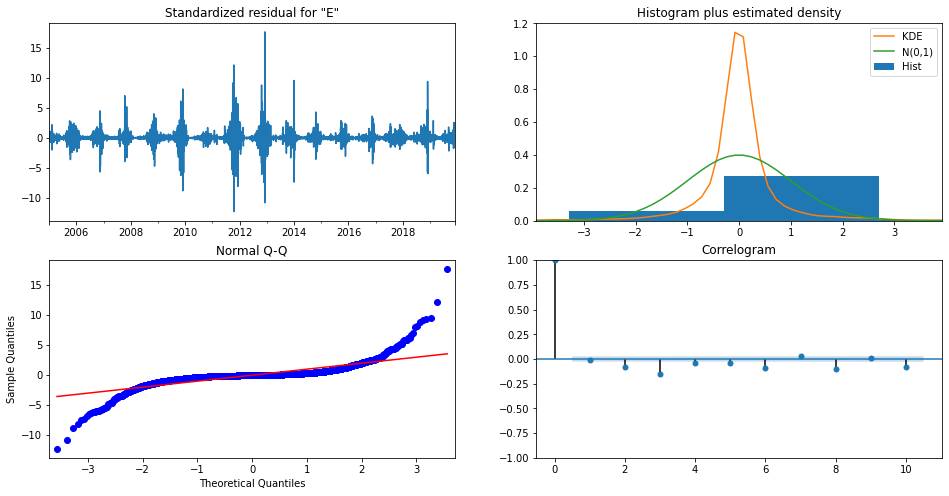

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = False 56.42


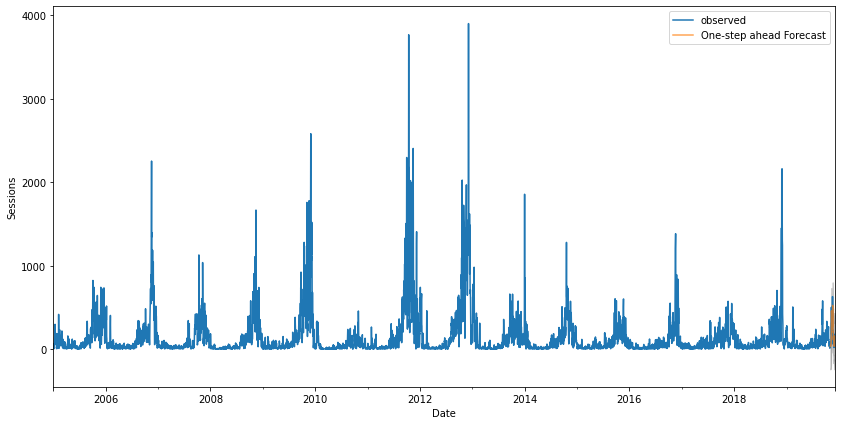

The Root Mean Squared Error of SARIMA with season_length=52 and dynamic = True 145.52


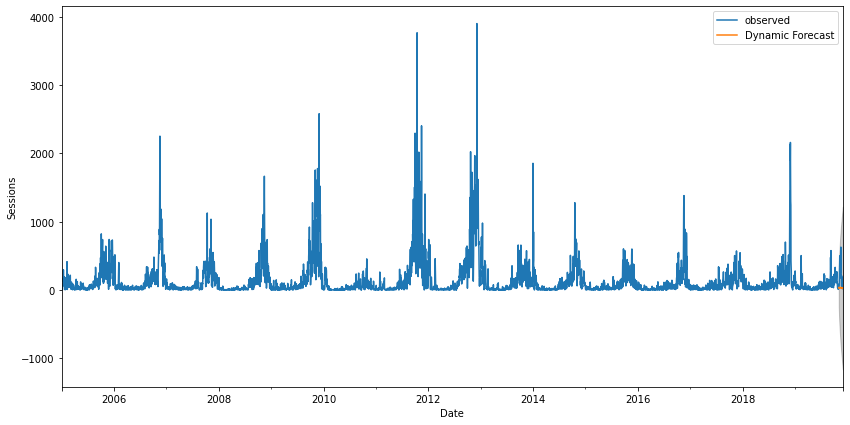

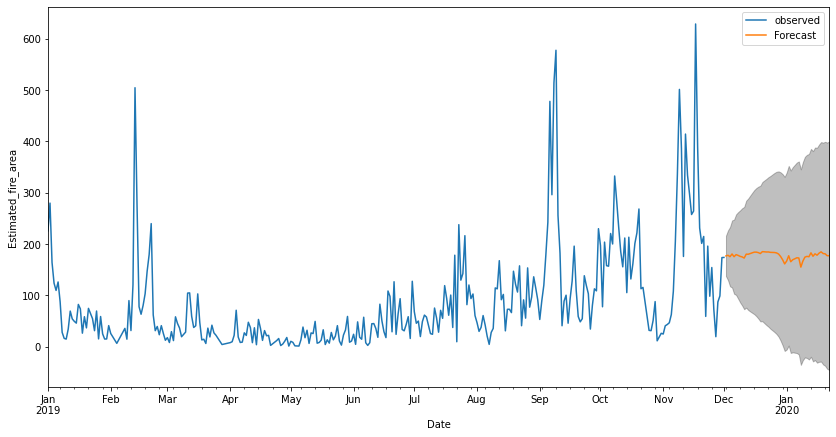

Predicted_Mean   -151.65572581
Lower Bound      -303.39682851
Upper Bound         0.08537689
dtype: float64

In [38]:
d = pmdarima.arima.ndiffs(QL_fires['Estimated_fire_area']) 
D = pmdarima.arima.nsdiffs(QL_fires['Estimated_fire_area'], 365)

model = sarima_eva(y,(1, d, 0),(1, D, 0, 52),52,'2019-11-02',y_to_val)

final_table = forecast(model,52,y['2019-01-01':])
 
validateResult(final_table.set_index('Date'), QL_fires)

### ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df_region['Temperature_Max'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
df = df_region['Temperature_Mean']
df

In [ ]:
d = pmdarima.arima.ndiffs(QL_fires['Estimated_fire_area']) 
D = pmdarima.arima.nsdiffs(QL_fires['Estimated_fire_area'], 365)

# Ignore harmless warnings 
warnings.filterwarnings("ignore") 
  
# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(QL_fires['Estimated_fire_area'],
                          m = 365, seasonal = False, 
                          d = d, D = D, trace = True, 
                          error_action ='ignore',
                          suppress_warnings = True,
                          stepwise = True)
  
# To print the summary 
stepwise_fit.summary() 

In [ ]:
# Split data into train / test sets 
training_length = 365
train = QL_fires.iloc[:len(QL_fires)-training_length] 
test = QL_fires.iloc[len(QL_fires)-training_length:]
  
model = SARIMAX(train['Estimated_fire_area'],  
                order = (5, 1, 5),  
                seasonal_order =(0, 0, 0, training_length)) 
  
result = model.fit() 
result.summary()

In [ ]:
start = len(train) 
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set 
predictions = result.predict(start, end, 
                             typ = 'levels').rename("Predictions") 
  
# plot predictions and actual values 
predictions.plot(legend = True) 
test['Estimated_fire_area'].plot(legend = True) 


In [ ]:
df = QL_fires.reset_index()
df = pd.DataFrame(df['Estimated_fire_area'])
df.rename(columns = {'Estimated_fire_area':'value'}, inplace = True) 

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(QL_fires['Estimated_fire_area'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [ ]:
from pmdarima.arima.utils import ndiffs
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
y = df.value

## Adf Test
a = ndiffs(y, test='adf')  # 2

# KPSS test
b = ndiffs(y, test='kpss')  # 0

# PP test:
c = ndiffs(y, test='pp')  # 2

print(a, b, c)

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1])

plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.value, order=(1,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [ ]:
model_fit.plot_predict(dynamic=False, start=5500)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.value[:100]
test = df.value[100:]

In [ ]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(5683, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
t = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)